In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Data Overview

In [29]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1')

df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Cleaning	

In [30]:
# Drop rows with missing CustomerID to ensure valid customer segmentation
# CustomerID is crucial for identifying unique customers
df = df.dropna(subset=['CustomerID'])

# Remove transactions with non-positive quantity or unit price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime format to handle date operations
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove cancelled transactions (those starting with 'C' in InvoiceNo)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029

### Feature Engineering (RFM)

In [31]:
# Create TotalPrice column to calculate monetary value
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Define reference date (the day after the latest transaction)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index (optional, for better display)
rfm = rfm.reset_index()

print(rfm.head())
print(rfm.describe())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


### EDA 

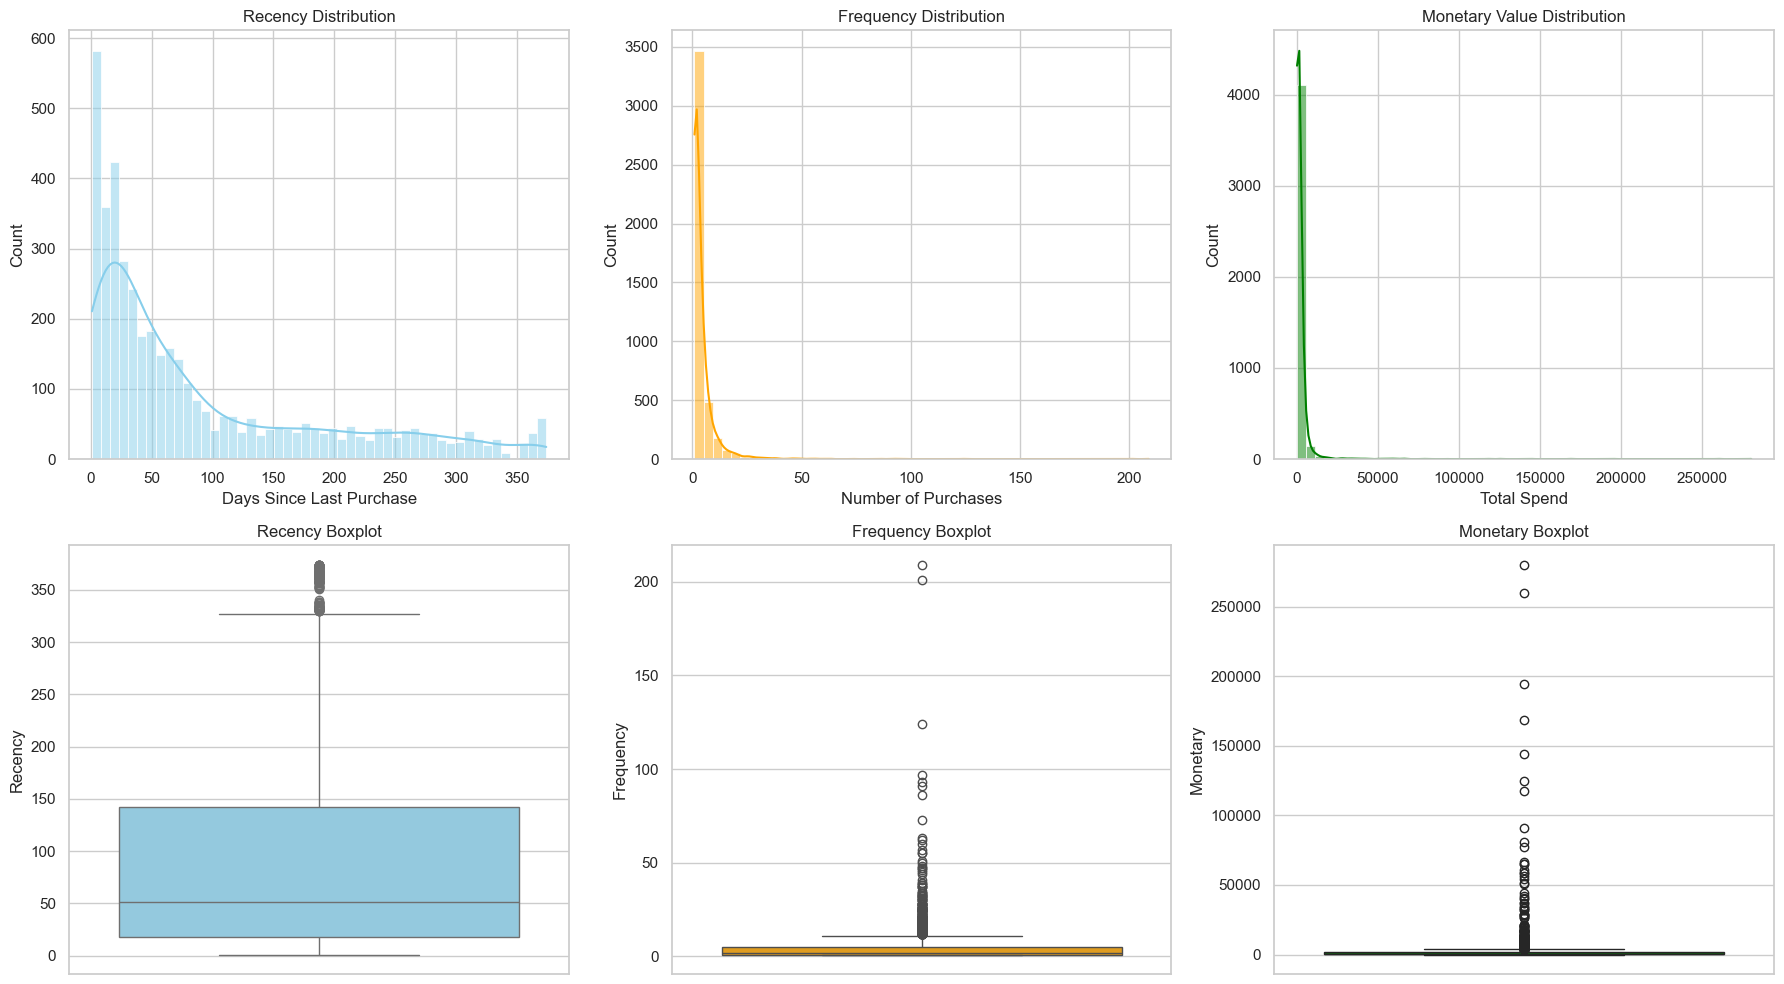

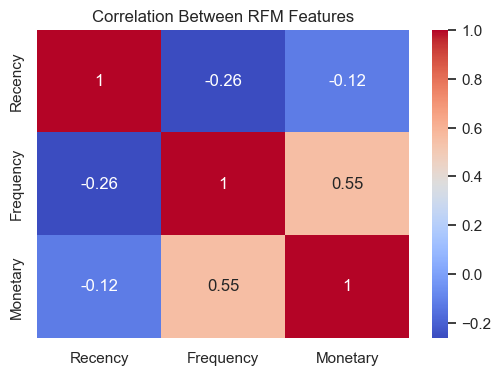

In [32]:
# Set style
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --------- Row 1: Histograms ---------
# Recency Histogram
sns.histplot(rfm['Recency'], kde=True, bins=50, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Recency Distribution')
axes[0, 0].set_xlabel('Days Since Last Purchase')

# Frequency Histogram
sns.histplot(rfm['Frequency'], kde=True, bins=50, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_xlabel('Number of Purchases')

# Monetary Histogram
sns.histplot(rfm['Monetary'], kde=True, bins=50, color='green', ax=axes[0, 2])
axes[0, 2].set_title('Monetary Value Distribution')
axes[0, 2].set_xlabel('Total Spend')

# --------- Row 2: Boxplots ---------
# Recency Boxplot
sns.boxplot(y=rfm['Recency'], color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('Recency Boxplot')

# Frequency Boxplot
sns.boxplot(y=rfm['Frequency'], color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Frequency Boxplot')

# Monetary Boxplot
sns.boxplot(y=rfm['Monetary'], color='green', ax=axes[1, 2])
axes[1, 2].set_title('Monetary Boxplot')

# Layout adjustment
plt.tight_layout()
plt.show()

# --------- Correlation Heatmap ---------
plt.figure(figsize=(6, 4))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between RFM Features')
plt.show()

### Preprocessing (Log + Scaling)

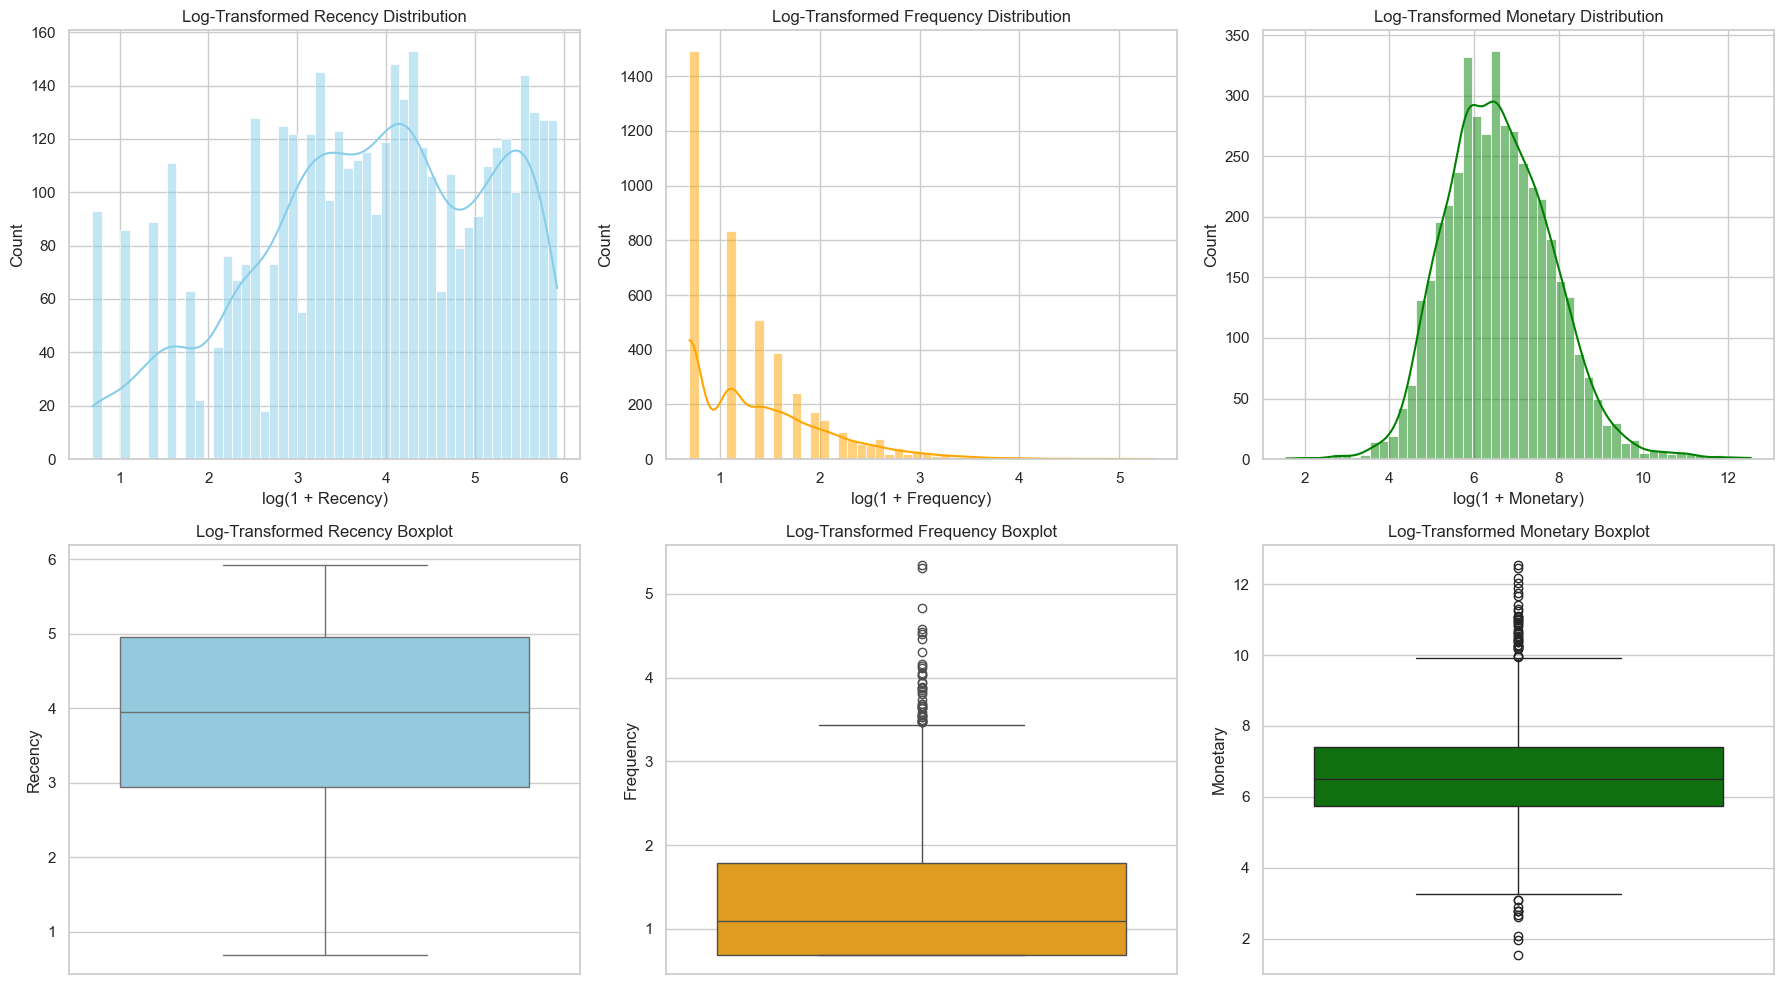

In [33]:
# Apply log(1 + x) to avoid log(0)
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])


# Set style
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --------- Row 1: Histograms ---------
# Recency Histogram (log)
sns.histplot(rfm_log['Recency'], kde=True, bins=50, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Log-Transformed Recency Distribution')
axes[0, 0].set_xlabel('log(1 + Recency)')

# Frequency Histogram (log)
sns.histplot(rfm_log['Frequency'], kde=True, bins=50, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Log-Transformed Frequency Distribution')
axes[0, 1].set_xlabel('log(1 + Frequency)')

# Monetary Histogram (log)
sns.histplot(rfm_log['Monetary'], kde=True, bins=50, color='green', ax=axes[0, 2])
axes[0, 2].set_title('Log-Transformed Monetary Distribution')
axes[0, 2].set_xlabel('log(1 + Monetary)')

# --------- Row 2: Boxplots ---------
# Recency Boxplot (log)
sns.boxplot(y=rfm_log['Recency'], color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('Log-Transformed Recency Boxplot')

# Frequency Boxplot (log)
sns.boxplot(y=rfm_log['Frequency'], color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Log-Transformed Frequency Boxplot')

# Monetary Boxplot (log)
sns.boxplot(y=rfm_log['Monetary'], color='green', ax=axes[1, 2])
axes[1, 2].set_title('Log-Transformed Monetary Boxplot')

# Layout adjustment
plt.tight_layout()
plt.show()


In [34]:
# Select only RFM values (excluding CustomerID)
rfm_features = rfm_log[['Recency', 'Frequency', 'Monetary']]

# Apply StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(rfm_scaled_df.describe())

            Recency     Frequency      Monetary
count  4.338000e+03  4.338000e+03  4.338000e+03
mean  -8.025955e-17 -8.189750e-18  2.817274e-16
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -2.341296e+00 -9.552143e-01 -4.004574e+00
25%   -6.613615e-01 -9.552143e-01 -6.856676e-01
50%    8.992557e-02 -3.615828e-01 -6.218718e-02
75%    8.447915e-01  6.532370e-01  6.541861e-01
max    1.564198e+00  5.858535e+00  4.731591e+00


### Clustering (Elbow + KMeans)	

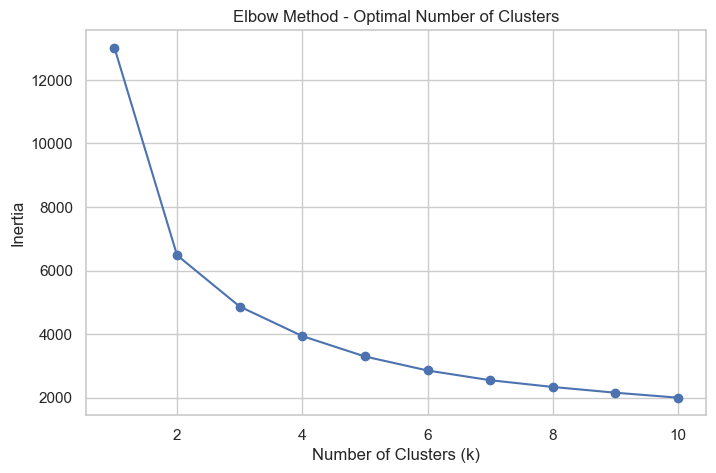

In [35]:
# Test k from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [36]:
# Apply KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Add cluster back to original RFM DataFrame (non-scaled, non-log)
rfm['Cluster'] = rfm_scaled_df['Cluster']



### Visualization of Clusters	

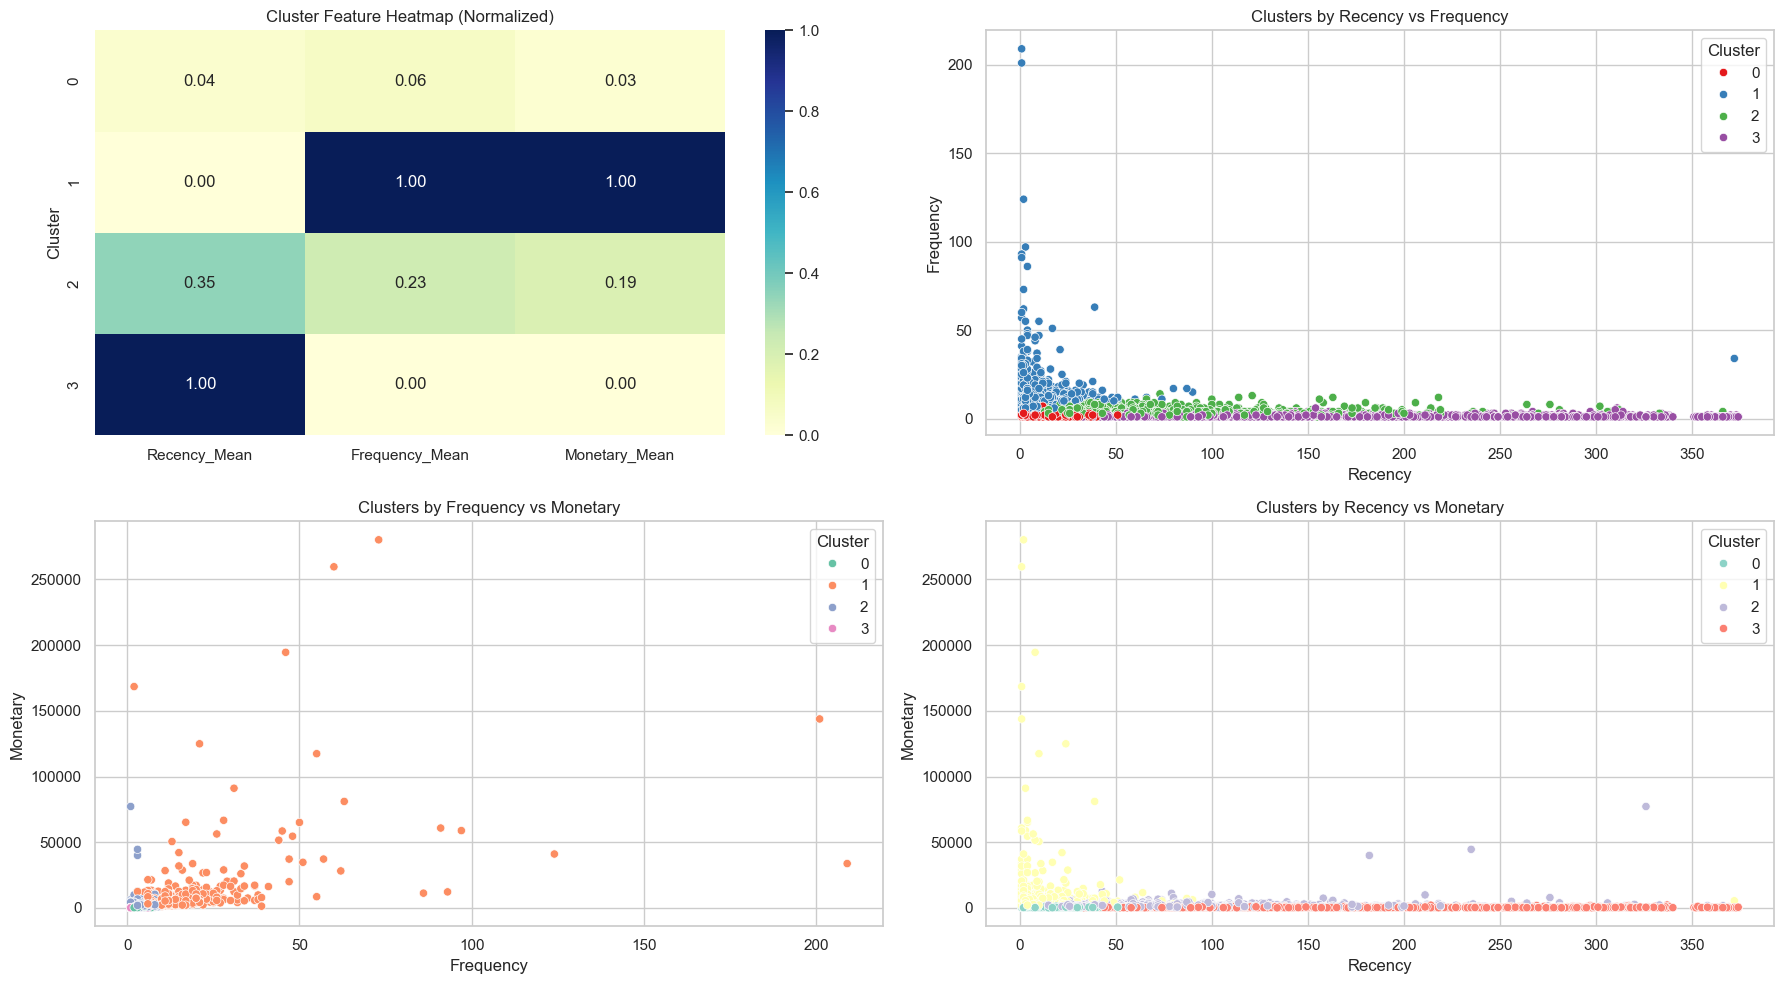

In [37]:
# Prepare layout for all visualizations in one figure
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# --------- Plot 1: Cluster Feature Heatmap (Normalized) ---------
cluster_norm = cluster_summary[['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]
cluster_norm = (cluster_norm - cluster_norm.min()) / (cluster_norm.max() - cluster_norm.min())
sns.heatmap(cluster_norm, annot=True, cmap='YlGnBu', fmt='.2f', ax=axes[0, 0])
axes[0, 0].set_title('Cluster Feature Heatmap (Normalized)')

# --------- Plot 2: Recency vs Frequency ---------
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set1', ax=axes[0, 1])
axes[0, 1].set_title('Clusters by Recency vs Frequency')

# --------- Plot 3: Frequency vs Monetary ---------
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Clusters by Frequency vs Monetary')

# --------- Plot 4: Recency vs Monetary ---------
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set3', ax=axes[1, 1])
axes[1, 1].set_title('Clusters by Recency vs Monetary')

# Layout
plt.tight_layout()
plt.show()

### Insights + Business Actions	

** 🔵 Cluster 1 – "VIP Loyal Customers" **

🎯 Who are they?
- Highly active customers with frequent purchases and the highest total spending.

📈 Behavior Summary:
- Recency: 12 days
- Frequency: 13.7 purchases
- Monetary: 8,074 $

🧠 What does this tell us?
These are your most valuable customers. They’re loyal, engaged, and profitable — the kind of customers you build your business around.

📌 What to do:
- Offer loyalty rewards or exclusive VIP perks
- Send personalized thank-you emails or early access invitations
- Encourage referrals or feedback

💡 Business Value:
- Increasing the loyalty of this segment boosts Customer Lifetime Value (CLV) and reduces churn from your highest spenders.
---

** 🟢 Cluster 2 – "Previously Loyal, Now Inactive" **

🎯 Who are they?
- Customers who used to purchase often and spend well — but haven’t interacted recently.

📈 Behavior Summary:
- Recency: 71 days
- Frequency: 4.1 purchases
- Monetary: 1,802 $

🧠 What does this tell us?
These customers are fading away. They were once engaged — and could be again — but they need a nudge.

📌 What to do:
- Send limited-time win-back discounts
- Recommend products based on their past behavior
- Ask for feedback to understand what changed

💡 Business Value:
- Reactivating existing customers is cheaper than acquiring new ones — and the conversion rate is often higher.
---

** 🔴 Cluster 0 – "New but Low-Value Customers" **
🎯 Who are they?
- Recent customers with limited purchase activity and spending.

📈 Behavior Summary:
- Recency: 18 days
- Frequency: 2.1 purchases
- Monetary: 551 $

🧠 What does this tell us?
- They’re new and showing early interest — but haven’t yet become loyal or high-value.

📌 What to do:
- Onboarding email sequences with product recommendations
- Encourage second purchase with small-time incentives
- Use social proof or bundle deals

💡 Business Value:
- This segment represents growth potential. Nurturing them early could turn them into future VIPs.
---

** 🟣 Cluster 3 – "Dormant or Churned Customers" **
🎯 Who are they?
- Customers who haven’t purchased in a long time and didn’t spend much to begin with.

📈 Behavior Summary:
- Recency: 182 days
- Frequency: 1.3 purchases
- Monetary: 343 $

🧠 What does this tell us?
- They’re likely churned. These customers are the least engaged and least profitable.

📌 What to do:
- Try one last win-back campaign (deep discount or free shipping)
- Send a quick exit survey
- Remove them from ongoing campaigns to reduce marketing cost

💡 Business Value:
- By deprioritizing this group, you save marketing budget and focus on segments with higher return potential.



## Cluster Visualization using PCA
- We used PCA to reduce the 3-dimensional RFM data into 2 components, allowing us to visualize customer segments clearly. The plot shows good separation between clusters, confirming the effectiveness of our clustering.



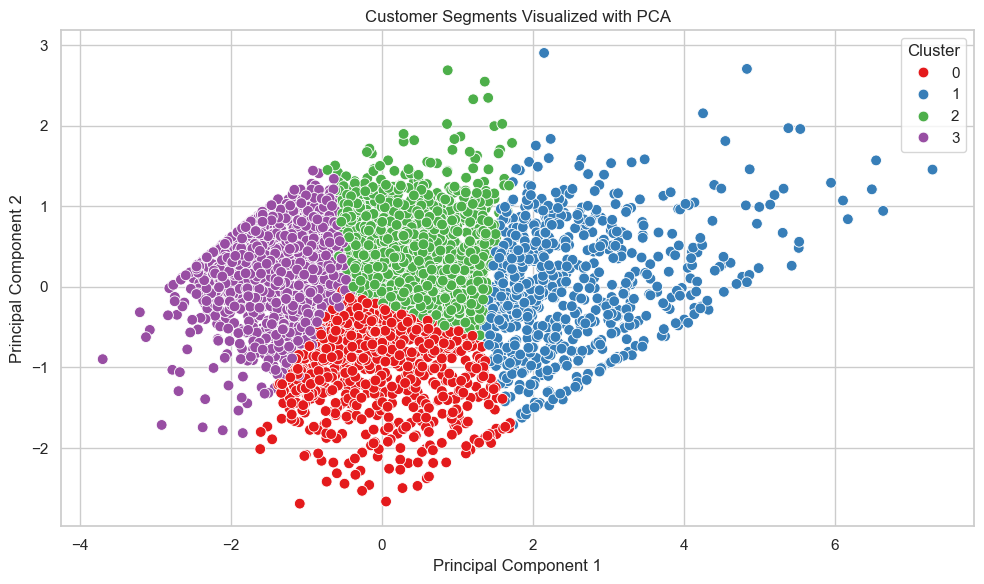

In [38]:
# Apply PCA to scaled RFM data
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Create DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm['Cluster'].values

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=60)
plt.title('Customer Segments Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()